In [16]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy import set_printoptions
set_printoptions(precision=3)
import pandas as pd
from pandas import DataFrame as df
from IPython.display import display

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from rgf.sklearn import RGFClassifier

from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,ShuffleSplit,StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,make_scorer,fbeta_score,roc_auc_score

import gini_metric as gm
import encoding as enc
import feature_engineering as fe
from stacking import Stacking

In [2]:
# *load data*
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv') 

In [3]:
# data shape
print('Train Shape: {}'.format(train_data.shape))
print('Test Shape: {}'.format(test_data.shape))

Train Shape: (595212, 59)
Test Shape: (892816, 58)


In [4]:
# *split data into X and y*
y=train_data['target'].values
X=train_data.drop(['target','id'],axis=1)
test_id=test_data['id'].values
X_test=test_data.drop(['id'],axis=1)

## Feature Engineering

In [29]:
# feature selection pipeline
def feature_selection(df):
    df.drop(['ps_ind_06_bin','ps_ind_07_bin','ps_ind_08_bin','ps_ind_09_bin',
            'ps_ind_10_bin','ps_ind_11_bin','ps_ind_12_bin','ps_ind_13_bin','ps_ind_14'],axis=1,inplace=True)
    df.drop(['ps_ind_10_bin','ps_ind_11_bin','ps_ind_12_bin','ps_ind_13_bin'],axis=1,inplace=True)
    df.drop(['ps_calc_17_bin','ps_calc_20_bin','ps_car_10_cat','ps_calc_15_bin','ps_calc_01','ps_calc_04'
              ,'ps_calc_09','ps_calc_14'],axis=1,inplace=True)
    # drop '_calc_' attributes
    cols=[col for col in X.columns if col.startswith('ps_calc_')]
    df.drop(cols,axis=1,inplace=True)
    return df

# feature interactions pipeline
def feature_interaction(base,df):
    base_nan=base.replace(-1,np.NaN)
    col_median=base_nan.median(axis=0)
    col_mean=base_nan.mean(axis=0)
    # construct feature interactions
    df['ps_car_13_reg_03']=df['ps_car_13']*df['ps_reg_03']
    df['neg_one_row_sum']=np.sum((df[df.columns]==-1).values,axis=1)
    #df['ps_reg_01_02_03']=df['ps_reg_01']*df['ps_reg_02']*df['ps_reg_03']
    #df['ps_ind_bins_sum']=df['ps_ind_06_bin']+df['ps_ind_07_bin']+df['ps_ind_08_bin']+df['ps_ind_09_bin'] \
    #+df['ps_ind_10_bin']+df['ps_ind_11_bin']+df['ps_ind_12_bin']+df['ps_ind_13_bin']+df['ps_ind_16_bin'] \
    #+df['ps_ind_17_bin']+df['ps_ind_18_bin']
    # binarize feature data
    for col in base.columns:
        if '_bin' not in col:
            df[col+str('_median_range')] = (df[col].values>col_median[col]).astype(np.int)
            df[col+str('_mean_range')] = (df[col].values>col_mean[col]).astype(np.int)
    return df

def one_hot_encode(base,df):
    unique_list={col:list(base[col].unique()) for col in base.columns}
    for col in unique_list:
        if len(unique_list[col])>2 and len(unique_list[col])<7:
            for val in unique_list[col]:
                df[col+'_ohe_'+str(val)]=(df[col].values==val).astype(np.int)
    return df

# duplicate rows removal pipeline
def duplicates_removal(base,df):
    col=[col for col in X.columns if not col.startswith('ps_calc_')]
    dups=base[base.duplicated(subset=col,keep=False)]
    df_no_dups=df[~(df.index.isin(dups.index))]
    return df_no_dups    

In [ ]:
# feature engineering
X_eng=feature_interaction(X,X)
X_test_eng=feature_interaction(X,X_test)

In [ ]:
# one-hot encoding
X_ohe=one_hot_encode(X,X)
X_test_ohe=one_hot_encode(X,X_test)

In [23]:
# remove duplicate rows from X and y
X_no_dups=duplicates_removal(X,X)
y_no_dups=duplicates_removal(X,df(y))

## Spot-Check Algorithms

In [5]:
# *set global parameter value*
random_state=2017
test_size=0.25

# *split train data into train and validation sets*
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=test_size,random_state=random_state)
print('Train samples: {}\nValidation samples: {}'.format(len(X_train),len(X_val)))

Train samples: 446409
Validation samples: 148803


### 1) XGBoost

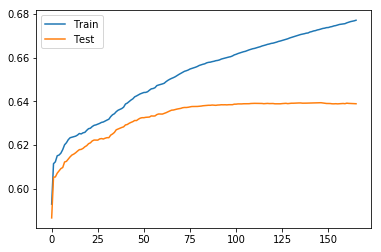

0.638960996024


In [14]:
# sklearn API
# initialize model
max_depth=4
n_estimators=200
learning_rate=0.1
subsample=0.8
colsample_bytree=0.8
model=XGBClassifier(max_depth=max_depth,n_estimators=n_estimators,learning_rate=learning_rate,
                    subsample=subsample,colsample_bytree=colsample_bytree,n_jobs=-1,random_state=random_state)

# fit to train & cross validation data
early_stopping_rounds=0.1*n_estimators # generally as a % (e.g. 10%) of training epochs
eval_set=[(X_train,y_train),(X_val,y_val)]
eval_metric='auc'
model.fit(X_train,y_train,early_stopping_rounds=early_stopping_rounds,eval_metric=eval_metric,
          eval_set=eval_set,verbose=False)
results=model.evals_result()

# plot learning curve 
rounds=len(results['validation_0']['auc'])
x_axis=range(0,rounds)
fig,ax=plt.subplots()
ax.plot(x_axis,results['validation_0']['auc'],label='Train')
ax.plot(x_axis,results['validation_1']['auc'],label='Test')
ax.legend()
plt.show()

# predictions
predicted=model.predict_proba(X_val)[:,1]

# model performance reports
print(roc_auc_score(y_val,predicted))

### 2) LightGBM

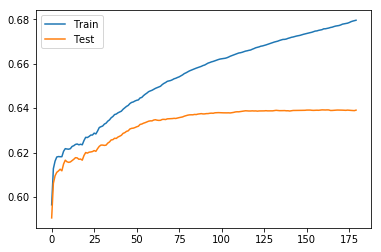

0.639222208015


In [15]:
# sklearn API
# initialize model
max_depth=4
n_estimators=200
learning_rate=0.1
subsample=0.8
colsample_bytree=0.8
model=LGBMClassifier(max_depth=max_depth,n_estimators=n_estimators,learning_rate=learning_rate,
                     subsample=subsample,colsample_bytree=colsample_bytree,n_jobs=-1,random_state=random_state)

# fit to train & cross validation data
early_stopping_rounds=0.1*n_estimators # generally as a % (e.g. 10%) of training epochs
eval_set=[(X_train,y_train),(X_val,y_val)]
eval_metric='auc'
model.fit(X_train,y_train,early_stopping_rounds=early_stopping_rounds,eval_metric=eval_metric,
          eval_set=eval_set,verbose=False)
results=model.evals_result_

# plot learning curve 
rounds=len(results['training']['auc'])
x_axis=range(0,rounds)
fig,ax=plt.subplots()
ax.plot(x_axis,results['training']['auc'],label='Train')
ax.plot(x_axis,results['valid_1']['auc'],label='Test')
ax.legend()
plt.show()

# predictions
predicted=model.predict_proba(X_val)[:,1]

# model performance reports
print(roc_auc_score(y_val,predicted))

## Algorithm Comparison - Cross Validation Pipeline

In [ ]:
# create pipeline for comparing model performances
models=[]
models.append(('xgboost',XGBClassifier()))
models.append(('lightgbm',LGBMClassifier()))

# run cross validation scoring
names=[]
scores=[]
cv=StratifiedShuffleSplit(n_splits=2,random_state=random_state,test_size=test_size)
#cv=StratifiedKFold(n_splits=2,shuffle=True,random_state=random_state)
scoring='roc_auc'
for name,model in models:
    cv_scores=cross_val_score(model,X,y,cv=cv,scoring=scoring,verbose=2,n_jobs=-1)
    scores.append(cv_scores)
    names.append(name)
    print('%s: %f%% (%f%%)'%(name,cv_scores.mean()*100.0,cv_scores.std()*100.0))

In [ ]:
# visualizing comparisons
fig=plt.figure()
fig.suptitle('Algorithm Comparison')
ax=fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)
plt.show()

## Ensemble - Stacking

In [12]:
class Stacking(object):  
    def __init__(self,n_splits,model,estimators):
        self.n_splits=n_splits
        self.model=model
        self.estimators=estimators
        
    def fit_predict(self,X,y,X_test):
        X=np.array(X)
        y=np.array(y)
        X_test=np.array(X_test)
        folds=list(StratifiedKFold(n_splits=self.n_splits,shuffle=True,random_state=2017).split(X,y))
        Y=np.zeros((X.shape[0],len(self.estimators)))
        Y_test=np.zeros((X_test.shape[0],len(self.estimators)))
        
        for i,estimator in enumerate(self.estimators):
            Y_test_i=np.zeros((X_test.shape[0],self.n_splits))
            for j,(train_i,val_i) in enumerate(folds):
                X_train=X[train_i]
                y_train=y[train_i]
                X_val=X[val_i]
                print('Fit %s on fold %d'%(str(estimator).split('(')[0],j+1))
                estimator.fit(X_train,y_train)
                predicted=estimator.predict_proba(X_val)[:,1]                
                Y[val_i,i]=predicted
                Y_test_i[:,j]=estimator.predict_proba(X_test)[:,1]
            Y_test[:,i]=Y_test_i.mean(axis=1)       
        scores=cross_val_score(self.model,Y,y,cv=3,scoring='roc_auc',n_jobs=-1)
        print('Model score: %.5f'%(scores.mean()))
        self.model.fit(Y,y)
        predicted=self.model.predict_proba(Y_test)[:,1]
        return predicted

In [13]:
# set params
xgb_params_1={
    'max_depth':4,
    'n_estimators':200,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8
}
lgb_params_1={
    'max_depth':4,
    'n_estimators':200,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8
}

# set estimators
xgb_model_1=XGBClassifier(**xgb_params_1)
lgb_model_1=LGBMClassifier(**lgb_params_1)

# initialize stacking
model=Stacking(n_splits=3,model=LogisticRegression(),estimators=(lgb_model_1,xgb_model_1))        

# fit to train data and predict on test data 
predicted=model.fit_predict(X,y,X_test)      

Fit LGBMClassifier fold 1
Fit LGBMClassifier fold 2
Fit LGBMClassifier fold 3
Fit XGBClassifier fold 1
Fit XGBClassifier fold 2
Fit XGBClassifier fold 3
Model score: 0.63949


## Optimization - Hyperparameter Tuning 

In [ ]:
# set hyperparameter grid
n_estimators=range(100,300,100)
max_depth=range(4,8,2)
learning_rate=[0.0001,0.001,0.01]
subsample=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
colsample_bytree=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
#colsample_bylevel=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
param_grid=dict(max_depth=max_depth,n_estimators=n_estimators)

# initialize grid search
n_splits=2
estimator=XGBClassifier()
scoring='roc_auc'
cv=StratifiedShuffleSplit(n_splits=n_splits,random_state=random_state,test_size=test_size)
model=GridSearchCV(estimator=estimator,param_grid=param_grid,scoring=scoring,cv=cv,n_jobs=-1,verbose=2)
model.fit(X,y)

# show search results
print("Best: %.3f%% using %s\n"%(model.best_score_*100.0,model.best_params_))
for mean,std,param in zip(model.cv_results_['mean_test_score'],model.cv_results_['std_test_score'],
                          model.cv_results_['params']):
    print("%.3f%% (%.3f%%) with: %r"%(mean*100.0,std*100.0,param))

In [ ]:
# visualize search results (scores)
# one parameter case
#plt.errorbar(param_type,means,yerr=stds)

# two parameters case
means=np.array(means).reshape(len(max_depth),len(n_estimators))
for i,value in enumerate(max_depth):
    plt.plot(n_estimators,means[i],label='Depth: '+str(value))
plt.legend()
plt.xlabel(param_name)
plt.ylabel('AUC')
plt.show()

## Create Submission File to Kaggle 

In [ ]:
# creat submission file for Kaggle
sub=pd.DataFrame()
sub['id']=test_id
sub['target']=pred
sub.to_csv('ps_xgb1.csv',index=False)